# Introduction

The European Transaction Log (EUTL) is the backbone of the European Union Emissions Trading System (EUETS). It implements the transfer of emission allowances between parties active in the EUETS. The EUTL provides data on regulated installations, their emissions as well as transfers of allowances.  

Assuming that the database has been successfully populated with the EUTL data (see 1_create_database.ipynb), this notebook illustrates how to analyze compliance and transactions on the registry level.

Specifically, we consider the German registry with the identifier DE.

In [1]:
id_reg = "DE"

# Packages and options

In [2]:
from pyeutl.orm import DataAccessLayer       # data access layer to access the database
from pyeutl.orm import Country, Installation  # use country class to access registries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Database connection settings

In [3]:
connectionSettings = dict(
    user="eutlAdmin", 
    host="localhost", 
    db="eutl_orm", 
    passw="1234",
    port=5432
)

# Connect to database

Connect to database and get a session:

In [4]:
dal = DataAccessLayer(**connectionSettings)
session = dal.session

# Get registry

Given the registry id, use the session to get the registry:

In [5]:
registry = session.query(Country).get(id_reg)
print(registry.id + ": " + registry.name)

DE: Germany


# Installations

## Low-level access: Get installation objects

The country object has a property "installations_in_registry" which returns the query to get all installations registered in the country. The property "installations_in_country" returns all installations located in the country. 

In [6]:
inst = registry.installations_in_registry
inst

Given the query we can either fetch the results:

In [7]:
inst.first()          # get only first results
inst.all()            # get all results
inst.limit(5).all()   # get first 5 results 

[<Installation('DE_200695', None, <Country('DE', 'Germany')>)>,
 <Installation('DE_200675', None, <Country('DE', 'Germany')>)>,
 <Installation('DE_200383', None, <Country('DE', 'Germany')>)>,
 <Installation('DE_201347', None, <Country('DE', 'Germany')>)>,
 <Installation('DE_201401', None, <Country('DE', 'Germany')>)>]

We could also further filter the results, e.g., getting all installations under activity 1 or 20 (combustion of fuels):

In [8]:
t_ = inst.filter(Installation.activity_id.in_([1, 20])).all()
print("Number of combustion installations: ", len(t_))

Number of combustion installations:  1497


## More easy: get_installations()

The low-level access is useful to directly get the installation objects which allows constructing different filters. For convenience, get_installations() implements a method that returns all installations in the registry as a Pandas dataframe.

In [9]:
inst = registry.get_installations()
inst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2832 entries, 0 to 2831
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   euEntitlement        2247 non-null   float64       
 1   eprtrID              2114 non-null   object        
 2   country_id           2832 non-null   object        
 3   isAircraftOperator   2832 non-null   bool          
 4   chEntitlement        9 non-null      float64       
 5   parentCompany        2060 non-null   object        
 6   latitudeEutl         11 non-null     float64       
 7   ec748_2009Code       202 non-null    object        
 8   subsidiaryCompany    1956 non-null   object        
 9   longitudeEutl        11 non-null     float64       
 10  permitDateEntry      2630 non-null   datetime64[ns]
 11  permitID             2630 non-null   object        
 12  latitudeGoogle       2626 non-null   float64       
 13  id                   2832 non-nul

To get an overview about the number of activities we can use a simple groupby operation but need to to be aware that some installations do not have a Nace code assigned:

In [10]:
inst.groupby("nace", dropna=False)[["id"]].count().sort_values("id", ascending=False).head(5)

,id
nace,
Steam and air conditioning supply,598
Production of electricity,257
Air transport,202
Manufacture of paper and paperboard,159
"Manufacture of bricks, tiles and construction products, in baked clay",152


Most installations provide either heat or electricity (or both). The large number of NaN results from aircraft operators that do not have a nace code assigned: 

In [11]:
inst[pd.isnull(inst.nace)].groupby(["activity", "activity_id"])[["id"]].count()\
        .sort_values("id", ascending=False).head(4)

,,id
activity,activity_id,
Combustion of fuels,20,57
Production of bulk chemicals,42,56
Combustion installations with a rated thermal input exceeding 20 MW,1,9
"Installations for the manufacture of ceramic products by firing, in particular roofing tiles, bricks, refractory bricks, tiles, stoneware or porcelain",8,5


The get_installation() method implements allows filtering installations based on installation attributes. For this, provide a dictionary with the installation attribute as key and a *list* as values. The dataframe returned only includes installations with attribute values as given in the respective list.

As an example, filter again for installations related to combustion activities:

In [12]:
filt = {"activity_id": [1, 20]}
t_ = registry.get_installations(filter=filt)
print("Number of combustion installations: ", len(t_))

Number of combustion installations:  1497


In [13]:
registry.get_installations(filter=filt).activity_id.unique()

array([20,  1], dtype=int64)

# Compliance

## Low-level: Using installation objects

Given a list of installation objects, we can analyze each installation in same manner as outline in the previous notebook. 

As an example, consider getting all compliance data for combustion activities in the selected registry:

In [14]:
comb = registry.installations_in_registry.filter(Installation.activity_id.in_([1, 20])).all()
print("Number of combustion installations: ", len(comb))

Number of combustion installations:  1497


Now follow the previous notebook and get the compliance data:

In [15]:
df_comb = pd.concat([c.get_compliance() for c in comb])
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38922 entries, 0 to 25
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   verifiedUpdated         38922 non-null  bool  
 1   verified                18171 non-null  object
 2   allocatedTotal          38922 non-null  int64 
 3   allocatedNewEntrance    597 non-null    object
 4   compliance_id           18875 non-null  object
 5   installation_id         38922 non-null  object
 6   reportedInSystem        38922 non-null  object
 7   surrendered             17680 non-null  object
 8   verifiedCummulative     18470 non-null  object
 9   allocated10c            0 non-null      object
 10  allocatedFree           21317 non-null  object
 11  euetsPhase              38922 non-null  object
 12  year                    38922 non-null  int64 
 13  surrenderedCummulative  18815 non-null  object
 14  compliance              18875 non-null  object
dtypes: bo

Accessing data in this way, has the advantage to be rather flexible in allowing to access that data for each installation. However, that comes at performance cost. Moreover, you either need to join installation information like names and activities or to further aggregate the data. 

Therefore, the country object provides further methods that already include these information and aggregations.

## High level: get_compliance()

get_compliance() returns a dataframe of compliance data related to the registry including limited installation details:

In [16]:
df_comp = registry.get_compliance()
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75777 entries, 0 to 75776
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   installation_id       75777 non-null  object 
 1   installation_name     68380 non-null  object 
 2   activity_id           75777 non-null  int64  
 3   activity              75777 non-null  object 
 4   nace_id               71981 non-null  object 
 5   nace                  71981 non-null  object 
 6   year                  75777 non-null  int64  
 7   surrendered           30210 non-null  float64
 8   verified              31507 non-null  float64
 9   allocatedTotal        75777 non-null  int64  
 10  allocatedFree         38135 non-null  float64
 11  allocated10c          14 non-null     float64
 12  allocatedNewEntrance  1254 non-null   float64
 13  nace_category         75777 non-null  object 
 14  activity_category     75777 non-null  object 
dtypes: float64(5), int6

The frame allows to easily aggregate compliance data by the respective dimension. As an example, plot verified emissions by NACE category over time:

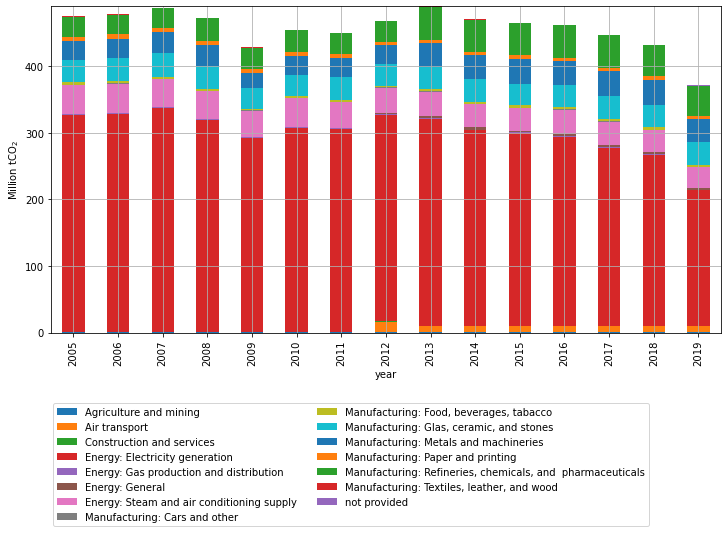

In [17]:
ax = df_comp[df_comp.year < 2020].groupby(["year", "nace_category"], as_index=False)\
        .verified.sum()\
        .pivot_table("verified", "year", "nace_category", dropna=False).div(1000000)\
        .plot(kind="bar", stacked=True,  figsize=(12,6), ylabel=r"Million tCO$_2$", grid=True)
ax.legend(bbox_to_anchor=(0.9, -0.2), loc=0, ncol=2)

Likewise, by activity category:

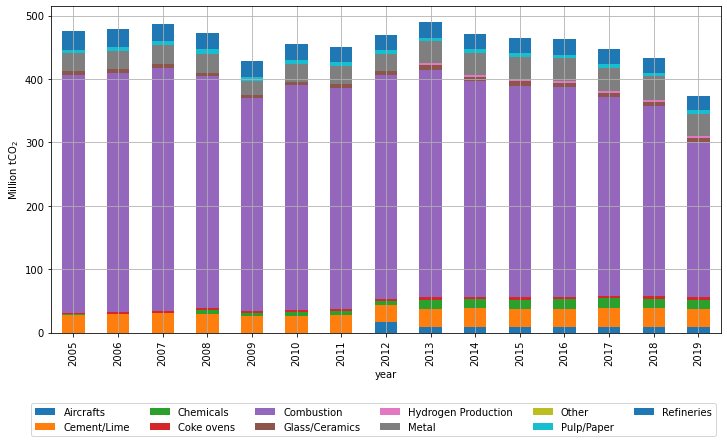

In [18]:
ax = df_comp[df_comp.year < 2020].groupby(["year", "activity_category"], as_index=False)\
        .verified.sum()\
        .pivot_table("verified", "year", "activity_category", dropna=False).div(1000000)\
        .plot(kind="bar", stacked=True,  figsize=(12,6), ylabel=r"Million tCO$_2$", grid=True)
ax.legend(bbox_to_anchor=(1, -0.2), loc=0, ncol=6)